In [2]:
%matplotlib inline
import pylab as plt
import jax.numpy as jnp
import seaborn as snb

from scipy.stats import binom as binom_dist
from scipy.stats import beta as beta_dist
from scipy.special import beta as beta_fun, comb


# Part 1: The beta-binomial model

Your friend has set up a website for her new business. So far N = 115 potential customers has visited her
site, but only y = 4 customers have completed a purchase. To plan her future investments, she asks you
for help to compute the probability that at least one of the next N∗ = 20 customers will make a purchase.
You decide to model the problem using the beta-binomial model with a uniform prior distribution on the
probability of making a purchase $\theta \in [0,1]$:

$$\theta \sim Beta(a_0,b_0)$$
$$y|\theta \sim Binomial(N,\theta)$$
Where $a_0=b_0=1$

---
**Task 1.1: Compute the prior mean of θ and provide a 95%-credibility interval for the prior.**
Hint: See Section 4.6.6 in Murphy1 for details on posterior/credibility intervals. The book discusses intervals
for posterior distribution, but we can also use credibility intervals to summarize prior distributions

In [3]:
#  Prior $p(\theta)=Beta(\theta|a_0,b_0)$ 
# 
a_0, b_0 = 1,1
prior = beta_dist(a_0, b_0)
print(f'Prior mean: {prior.mean()}')
print(f"The 95% credible interval is {prior.interval(0.95)}")

Prior mean: 0.5
The 95% credible interval is (np.float64(0.025000000000000022), np.float64(0.975))


---
**Task 1.2: Compute the posterior mean of θ and provide a 95%-credibility interval for the
posterior** 

In [4]:
# - Posterior $p(\theta|y) = Beta(\theta| y+a_0,N-y+b_0)$
y=4
N=115
a = a_0 + y
b = b_0 + N - y
posterior = beta_dist(a, b)
print(f'Posterior mean: {posterior.mean()}')
print(f"The 95% credible interval is {posterior.interval(0.95)}")


Posterior mean: 0.042735042735042736
The 95% credible interval is (np.float64(0.01414155664664075), np.float64(0.08593831005795628))


---
let y∗ denote the number of purchases during the next N∗ = 20 visits.

**Task 1.3: Compute and plot the posterior predictive distribution for $y^∗$ given y = 4.**

Compute the posterior predictive distribution
- $p(y^*=k|y)=\int p(y^*|\theta)p(\theta|y)d\theta=\int Bin(y|N^*,\theta)Beta(\theta|y+a_o,N-y+b_0)d\theta ={N^* \choose k} \theta^k(1-\theta)^{N^*-k}\frac{1}{B(\alpha,\beta)}\theta^{\alpha-1}(1-\theta)^{\beta-1}d\theta$
	- $= {N^* \choose k}\frac{1}{B(\alpha,\beta)}\int \theta^{k+\alpha-1}(1-\theta)^{\beta+N^*-k-1}d\theta$ 


this is the functional form of a beta density and hence


$={N^* \choose k}\frac{B(\alpha+k,\beta+N^*-k)}{B(\alpha,\beta)}$

Text(0.5, 1.0, 'Posterior predictive distribution')

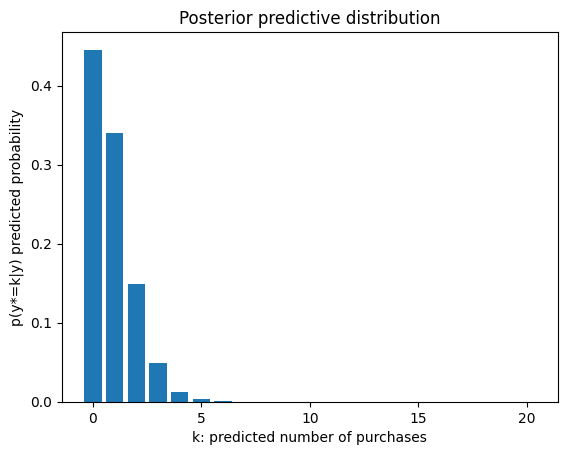

In [5]:
def posterior_predictive(N_star,k,a,b):
    return comb(N_star,k)*beta_fun(k+a,N_star-k+b)/beta_fun(a,b)
ks = jnp.linspace(0,20,21)
plt.bar(ks,posterior_predictive(20,ks,a,b))
plt.xlabel('k: predicted number of purchases')
plt.ylabel('p(y*=k|y) predicted probability')
plt.title('Posterior predictive distribution')

--- 

**Task 1.4: What is the posterior predictive probability that at least one of the next N∗ = 20 customers will make a purchase?**

In [6]:
print(f'The probability of observing at least 1 purchase in the next 20 customers is {1-posterior_predictive(20,0,a,b)}')

The probability of observing at least 1 purchase in the next 20 customers is 0.5543908502644432


---

**Task 1.5: Compute mean and variance of the posterior predictive distribution for $y^*$**

In [7]:
probs = posterior_predictive(20,ks,a,b)
print(f'The expected number of purchases in the next 20 customers is {jnp.sum(probs*ks)}')
print(f'The variance of the number of purchases in the next 20 customers is {jnp.sum(probs*ks**2)-jnp.sum(probs*ks)**2}')

The expected number of purchases in the next 20 customers is 0.8547009229660034
The variance of the number of purchases in the next 20 customers is 0.9499150514602661


# Part 2: Linear Gaussian systems

Let $z_1, z_2 ∈ \mathbb{R}^2$, and $y ∈ \mathbb{R}$ be random variables and consider the following linear Gaussian system

$
z_1 \sim \mathcal{N}(0, vI) \quad (3)
$

$
z_2 \mid z_1 \sim \mathcal{N}(z_1, vI) \quad (4)
$

$$
y \mid z_2 \sim \mathcal{N}(a^T z_2, \sigma^2) \quad (5)
$$

where $( a \in \mathbb{R}^2 )$ is constant. The joint distribution of $( (z_1, z_2, y) )$ is given by:

$$
p(y, z_1, z_2) = p(y \mid z_2) p(z_2 \mid z_1) p(z_1). \quad (6)
$$

To solve this part, you will need the equations for linear Gaussian systems in section 3.3 in Murphy1 as well
as the basic rules of probability theory (sum rule, product rule, conditioning).


---

**Task 2.1: Determine the distribution p(y).**
Hints: Compute $p(z_2)$ first. The equations for linear Gaussian systems in Section 3.3 in Murphy1 will behandy.

The given equations are:

$$
p(z_1) = \mathcal{N}(z_1|0, vI)
$$
$$
p(z_2 \mid z_1) = \mathcal{N}(z_2 \mid z_1, vI)
$$
$$
p(y \mid z_2) = \mathcal{N}(y|a^T z_2, \sigma^2)
$$


Moreover, from the book (equation (3.38))

$$p(z) = N(z|μ_z,Σ_z)$$

$$p(y|z) = N(y|W_z + b,Σ_y)$$

$$p(y)=\mathcal{N}(y|W\mu_z+b,\Sigma_y+W\Sigma_z W^T)$$


First we try to find $p(z_2)$ using the formula above and use $p(z_2)$ to find $p(y)$

$p(z_2)= \mathcal{N}(W\cdot0+0,vI+W\cdot vI \cdot W^T)$

since W is the identity matrix because $w_z+b=\mu_z$ 

$p(z_2)= \mathcal{N}(0,vI+vI )$

Apply again to get y 

$W=a^T$

$p(y)= \mathcal{N}(y|a^T \cdot 0,\sigma^2+a^T 2vI a)$


---

**Task 2.2: Determine the distribution $p(y, z_2|z_1)$.**

From conditional rule $p(y,z_2|z_1)=\frac{p(y,z_2,z_1)}{p(z_1)}$ where the joint distribution is given.
$$
p(y, z_1, z_2) = p(y \mid z_2) p(z_2 \mid z_1) p(z_1)
$$
Where
$$
p(z_1) = \mathcal{N}(z_1|0, vI)
$$

$$
p(z_2 \mid z_1) = \mathcal{N}(z_2 \mid z_1, vI)
$$

$$
p(y \mid z_2) = \mathcal{N}(y|a^T z_2, \sigma^2)
$$

putting all of the above together 
$$p(y,z_2|z_1)= \frac{\mathcal{N}(z_1|0, vI) \cdot \mathcal{N}(z_2 \mid z_1, vI) \cdot \mathcal{N}(y|a^T z_2, \sigma^2) }{ \mathcal{N}(z_1|0, vI)}$$

$$p(y,z_2|z_1)= \mathcal{N}(z_2 \mid z_1, vI) \cdot \mathcal{N}(y|a^T z_2, \sigma^2)$$

---

**Task 2.3: Determine the distribution $p(y|z_1)$**

From conditional independence rule $p(a,b|c)=p(a|c)p(b|c)$

$$p(y,z_2|z_1) = p(y|z_1)p(z_2|z_1) \to  p(y|z_1) = \frac {p(y,z_2|z_1)}{p(z_2|z_1)}$$

$$= \frac{\mathcal{N}(z_2 \mid z_1, vI) \cdot \mathcal{N}(y|a^T z_2, \sigma^2)}{\mathcal{N}(z_2 \mid z_1, vI)} =\mathcal{N}(y|a^T z_2, \sigma^2)$$

---

**Task 2.4: Determine the distribution $p(z_1|y)$.**

using Bayes rule for Gaussians (Also from the book)
$$
p(z|y)=\mathcal{N}(z|\mu_{z|y},\Sigma_{z|y})
$$
where 
$$
\Sigma_{z|y}^{-1}=\Sigma_z^{-1}+W^T\Sigma_y^{-1}W
$$
$$
\mu_{z|y}=\Sigma_{z|y} [W^T\Sigma_y^{-1}(y-b)+\Sigma_z^{-1}\mu_z]
$$

$\Sigma_{z|y}^{-1}=(vI)^{-1}+a\sigma^{-2}a^T$

$\mu_{z|y}=\Sigma_{z|y}[a\sigma^{-2}y+(vI)^{-1}*0]$

$\mu_{z|y}=\frac{a\sigma^{-2}y}{(vI+a\sigma^{-2}a^T)}$

$p(z|y)=\mathcal{N}(z|\frac{a\sigma^{-2}y}{(vI+a\sigma^{-2}a^T)},((vI)^{-1}+a\sigma^{-2}a^T)^{-1})$


using Bayes rule for Gaussians (Also from the book)
$$
p(z|y)=\mathcal{N}(z|\mu_{z|y},\Sigma_{z|y})
$$
where 
$$
\Sigma_{z|y}^{-1}=\Sigma_z^{-1}+W^T\Sigma_y^{-1}W
$$
$$
\mu_{z|y}=\Sigma_{z|y} [W^T\Sigma_y^{-1}(y-b)+\Sigma_z^{-1}\mu_z]
$$

$\Sigma_{z|y}^{-1}=(vI)^{-1}+a\sigma^{-2}a^T$

$\mu_{z|y}=\Sigma_{z|y}[a\sigma^{-2}y+(vI)^{-1}*0]$

$\mu_{z|y}=\frac{a\sigma^{-2}y}{(vI+a\sigma^{-2}a^T)}$

$p(z|y)=\mathcal{N}(z|\frac{a\sigma^{-2}y}{(vI+a\sigma^{-2}a^T)},(vI+a\sigma^{-2}a^T)^{-1})$


# Part 3: A conjugate model for count data
In week 1, we studied the Beta-binomial model, which is an example of a so-called **conjugate model**. In this exercise, you will work with another conjugate model, namely the **Poisson-Gamma model**, where the likelihood takes the form of a Poisson distribution,  $y_i \mid \lambda \sim \text{Poisson}(\lambda)$  with rate  $\lambda > 0,$  and the prior on  $\lambda$  is a Gamma distribution, i.e.,  $\lambda \sim \text{Gamma}(a_0, b_0),$  where  $a_0 > 0$  and  $b_0$  are hyperparameters known as the **shape** and **rate**, respectively.  

The Poisson distribution is a discrete distribution, which is often applied to model **count data**, where  $y_i \in \{0, 1, 2, \dots\}$  are non-negative integers. The probability mass function (PMF) for the Poisson distribution is:  $$
p(y_i \mid \lambda) = \frac{\lambda^{y_i} e^{-\lambda}}{y_i!} \quad (7)$$ 

for  $y_i \in \{0, 1, 2, \dots\}.$  

The Gamma distribution, e.g.,  $\lambda \sim \text{Gamma}(a_0, b_0),$  is a distribution over the non-negative real line, i.e.,  $\lambda > 0,$  with the following probability density function (PDF):  
$$
p(\lambda \mid a_0, b_0) = \frac{b_0^{a_0}}{\Gamma(a_0)} \lambda^{a_0 - 1} e^{-b_0 \lambda} \quad (8)$$

where $\Gamma(x)$  is the gamma function.  Consider now the following model:  
$$
y_i \mid \lambda \sim \text{Poisson}(\lambda) \quad (9)$$  
$$
\lambda \sim \text{Gamma}(a_0, b_0) \quad (10)$$  
where  $\{ y_i \}$  are assumed to be *conditionally independent* given  $\lambda.$  Suppose we collect  $N$  observations such that:  $y = \{ y_i \}_{i=1}^N.$  

---
**Task 3.1: Determine the joint distribution of (y, λ)**

We can decompose the likelihood using the conditional independence $p(y_1,y_2|\theta)=p(y_1|\theta)p(y_2|\theta)=\prod_{n=1}^N p(y_n|\theta)$. Moreover, joint distribution will be (from the Product rule) $p(y,\lambda)=p(y|\lambda)p(\lambda)=\prod_{n=1}^Np(y_n|\lambda)p(\lambda)$. 

where $p(y_i \mid \lambda) = \frac{\lambda^{y_i} e^{-\lambda}}{y_i!}$ hence 

$$p(y,\lambda)=p(y|\lambda)p(\lambda)=\prod_{n=1}^N\frac{e^{-\lambda} \lambda^{y_n}}{y_n!}p(\lambda)=e^{-N\lambda}\prod_{n=1}^N\frac{\lambda^{y_n}}{y_n!}p(\lambda)$$ 

and from equation (8) 

$$p(\lambda \mid a_0, b_0) = \frac{b_0^{a_0}}{\Gamma(a_0)} \lambda^{a_0 - 1} e^{-b_0 \lambda}$$ 

Therefore

$p(y,\lambda)=e^{-N\lambda}(\prod_{n=1}^N\frac{\lambda^{y_n}}{y_n!})\frac{b_0^{a_0}}{\Gamma(a_0)} \lambda^{a_0 - 1} e^{-b_0 \lambda} $. 

---
**Task 3.2: Show that the functional form of a Gamma distribution is given by $\log p(λ|a, b) =(a − 1) \log(λ) − bλ + constant$.**

$p(\lambda \mid a, b) = \frac{b^{a}}{\Gamma(a)} \lambda^{a - 1} e^{-b \lambda}$

take the natural log at both sides from some reason 

$\ln p(\lambda \mid a, b) = \ln(\frac{b^{a}}{\Gamma(a)})+\ln( \lambda^{a - 1})+\ln (e^{-b \lambda}) $

$= constant + (a - 1)\ln(\lambda)-b \lambda$


---
**Task 3.3: Derive the analytical expression for the posterior distribution p(λ|y) and show that it is a Gamma-distribution**


Posterior distribution can be obtained by using bayes rule  $p(\lambda|y)=\frac{p(y|\lambda)p(\lambda)}{p(y)}$. the evidence p(y) is independent on $\lambda$ hence the posterior is proportional to  $\propto p(y|\lambda)p(\lambda) \to \ln(p(\lambda|y)) \propto \ln(p(y|\lambda)) \ln(p(\lambda))$????????????????? 

 $$p(y|\lambda) = \prod_{n=1}^N \frac{\lambda^{y_n}e^{-\lambda}}{y_i!} \to$$
 
 $$\ln(p(y|\lambda))=\sum_{n=1}^N \ln(\lambda)y_n+\lambda-\ln(y_n!)$$

$$p(\lambda \mid a_0, b_0) = \frac{b_0^{a_0}}{\Gamma(a_0)} \lambda^{a_0 - 1} e^{-b_0 \lambda} \to ln(p(\lambda \mid a_0, b_0)) = a_0\ln(b_0)-\ln(\Gamma(a_0))+(a_0-1)*\ln(\lambda)-b_0*\lambda$$

Simplifying and joining constant terms together

$\ln p(\lambda|y)\propto -\lambda (N+b_0)+\ln(\lambda)(a_0-Y)+constant$
where $Y=\sum_{n=1}^Ny_n$

which has the functional form of a Gamma-distribution as seen in 3.2 where $a=a_0+Y+1$  and $b=b_0+N$



---
Suppose we observe $y_1 = 7$, $y_2 = 4$, $y_3 = 8$, $y_4 = 11$, and $y_5 = 12$ such that $N = 5$. Assume $a_0 = 1$ and $b_0 = \frac{1}{10}$

**Task 3.4: Determine the posterior distribution for λ given the data above and report the mean.**

Hints: If $λ ∼ Gamma(a, b)$, then $\mathbb{E} [λ] = \frac{a}{b}$

In [21]:
from scipy.stats import gamma

y= [7, 4, 8, 11, 12]
a_0 = 1
b_0 = 1/10
N = len(y)
posterior_G = gamma(a_0 + sum(y)+1, scale=1/(N+b_0))
print(f'Posterior mean: {posterior_G.mean()}')
print((a_0 + sum(y)+1)/(N+b_0))


Posterior mean: 8.627450980392158
8.627450980392158


---
**Task 3.5: Plot p(λ) and p(λ|y) for λ ∈ [0, 30].**
Hints: Implement the log density first for numeric stability. The function scipy.stats.gammaln implements the logarithm of the Γ(x) function, i.e. log Γ(x).

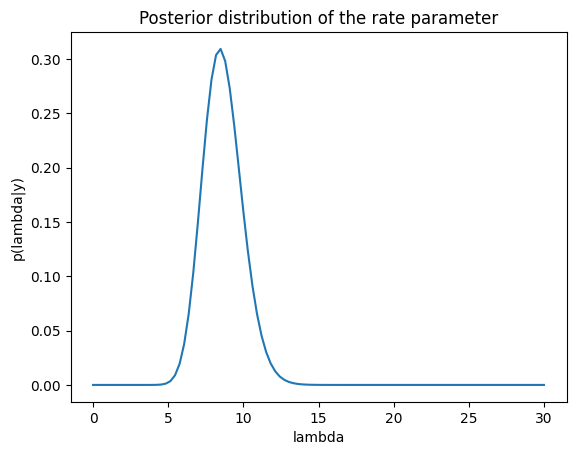

Prior mean: 10.0


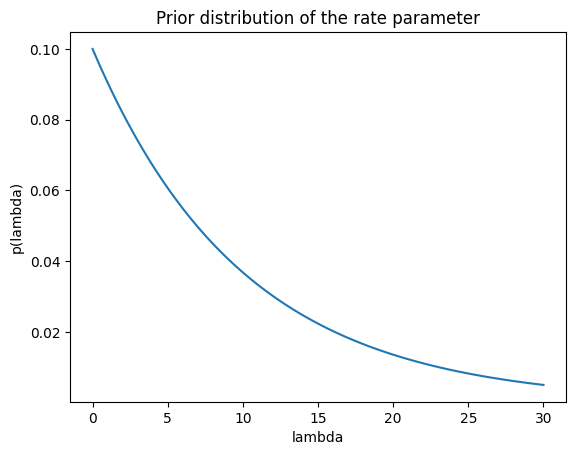

In [22]:
lambdas = jnp.linspace(0,30,100)
plt.plot(lambdas,posterior_G.pdf(lambdas))
plt.title('Posterior distribution of the rate parameter')
plt.xlabel('lambda')
plt.ylabel('p(lambda|y)')
plt.show()

prior_G = gamma(a_0, scale=1/b_0)
print(f'Prior mean: {prior_G.mean()}')
plt.plot(lambdas,prior_G.pdf(lambdas))
plt.title('Prior distribution of the rate parameter')
plt.xlabel('lambda')
plt.ylabel('p(lambda)')
plt.show()
